In [ ]:
# %pip install numpy matplotlib oasis-deconv

In [138]:
import numpy as np
import matplotlib.pyplot as plt
from oasis.functions import deconvolve

In [ ]:
from oasis.functions import gen_data
fluorescence_trace_1, clean_calcium_trace_1, spike_train_1 = map(np.squeeze, gen_data(b=0.0, N=1, sn=0.1))
fluorescence_trace_2, clean_calcium_trace_2, spike_train_2 = map(np.squeeze, gen_data(b=1.0, N=1, sn=0.3))
fluorescence_trace_3, clean_calcium_trace_3, spike_train_3 = map(np.squeeze, gen_data(b=5.0, N=1, sn=0.5))
fluorescence_trace_4, clean_calcium_trace_4, spike_train_4 = map(np.squeeze, gen_data(b=0.1, N=1, sn=0.))
fluorescence_trace_5, clean_calcium_trace_5, spike_train_5 = map(np.squeeze, gen_data(b=0.5, N=1, sn=0.01))

# Thresholding and Events: Converting Continuous Calcium Traces into Discrete Event Times

In this module, we will learn how to identify neural events from continuous ΔF/F₀ calcium traces. Calcium imaging data is inherently noisy and indirect, so interpreting neural activity requires identifying discrete moments — “events” — that indicate when neurons were likely active. This transition from continuous to event-based data is a critical step in calcium analysis and underpins much of what we do next: aligning events with stimuli, comparing across trials, or computing firing rates. We will explore both simple and advanced ways to extract event times, using tools ranging from NumPy to the OASIS spike inference algorithm.


## Section 1: Detecting Suprathreshold Activity with NumPy

In this section, we will use simple NumPy-based thresholding to identify moments of elevated activity in a calcium trace. The goal is to mark time points where the signal is likely meaningful — that is, when a neuron may have fired. This approach is based on statistical thresholds derived from the trace itself, and while it does not provide precise spike inference, it introduces the idea of event detection and is a helpful stepping stone to more advanced methods. You will use basic descriptive statistics and logical indexing to isolate high-activity points in the signal.

#### Learning Goals:
- Compute baseline and noise statistics using the mean and standard deviation of the ΔF/F₀ trace.
- Set a detection threshold and identify all time points where the signal exceeds this threshold.
- Use `np.where()` and logical masks to extract suprathreshold indices.
- Visualize the calcium trace alongside the detected activity points for verification.

**Calculate baseline**

In [ ]:
np.mean(fluorescence_trace_1)

np.float64(0.3285155849365434)

In [31]:
np.mean(fluorescence_trace_2)

np.float64(1.3322134657808302)

In [32]:
np.mean(fluorescence_trace_3)

np.float64(5.335911346625117)

In [33]:
np.mean(fluorescence_trace_4)

np.float64(0.4266666445144001)

In [34]:
np.mean(fluorescence_trace_5)

np.float64(0.8268515385566144)

**Calculate Noise**

In [ ]:
np.std(fluorescence_trace_1)

np.float64(0.4045505861920377)

In [14]:
np.std(fluorescence_trace_2)

np.float64(0.48926105451962026)

In [15]:
np.std(fluorescence_trace_3)

np.float64(0.6293972979185025)

In [16]:
np.std(fluorescence_trace_4)

np.float64(0.39521777746731745)

In [17]:
np.std(fluorescence_trace_5)

np.float64(0.39500847415854395)

**Setting threshold**

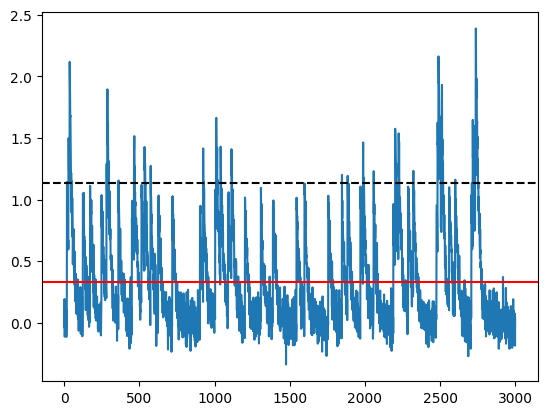

In [ ]:
mean = np.mean(fluorescence_trace_1)
std = np.std(fluorescence_trace_1)
treshold_factor = 2.0
det_treshold = mean + treshold_factor*std

plt.plot(fluorescence_trace_1)
plt.axhline(mean, color='r')
plt.axhline(det_treshold, ls='--', color='k')

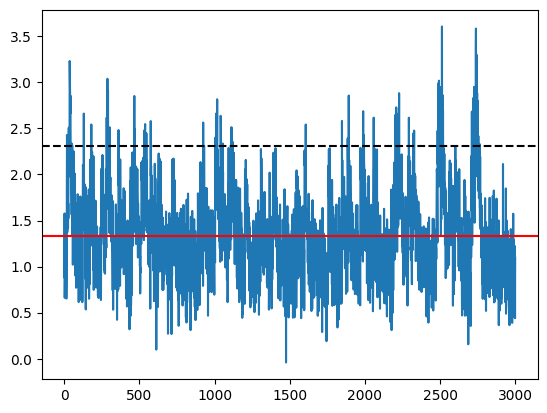

In [41]:
mean = np.mean(fluorescence_trace_2)
std = np.std(fluorescence_trace_2)
treshold_factor = 2.0
det_treshold = mean + treshold_factor*std

plt.plot(fluorescence_trace_2)
plt.axhline(mean, color='r')
plt.axhline(det_treshold, ls='--', color='k')

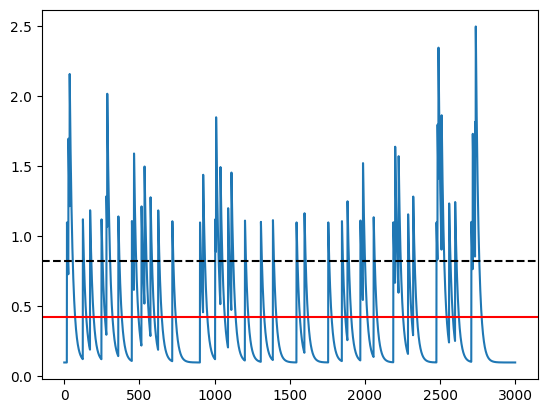

In [44]:
mean = np.mean(fluorescence_trace_4)
std = np.std(fluorescence_trace_4)
treshold_factor = 1.0
det_treshold = mean + treshold_factor*std

plt.plot(fluorescence_trace_4)
plt.axhline(mean, color='r')
plt.axhline(det_treshold, ls='--', color='k')

**Count how many events occurred**

In [ ]:
treshold_factor = 2.0
det_treshold = np.mean(fluorescence_trace_1) + treshold_factor * np.std(fluorescence_trace_1)
candidate_events = np.where(fluorescence_trace_1 > det_treshold)[0]

len(candidate_events)

147

In [54]:
treshold_factor = 2.0
det_treshold = np.mean(fluorescence_trace_2) + treshold_factor * np.std(fluorescence_trace_2)
candidate_events = np.where(fluorescence_trace_2 > det_treshold)[0]

len(candidate_events)

120

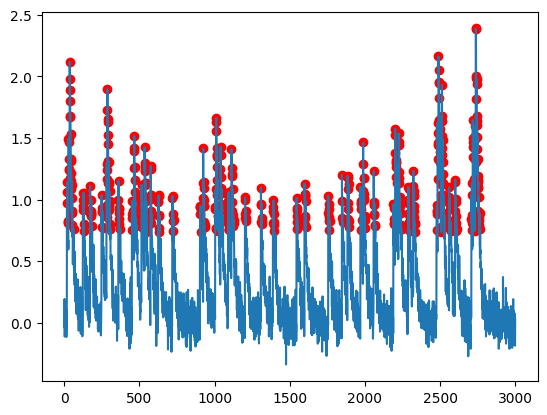

In [ ]:
treshold_factor = 1.0
det_treshold = np.mean(fluorescence_trace_1) + treshold_factor * np.std(fluorescence_trace_1)
candidate_events = np.where(fluorescence_trace_1 > det_treshold)[0]

plt.plot(fluorescence_trace_1)
plt.scatter(np.arange(len(fluorescence_trace_1))[candidate_events], fluorescence_trace_1[candidate_events], color='r')



## Section 2: Converting Suprathreshold Frames into Timestamps

Once we have identified where the calcium trace exceeds a threshold, the next step is to determine when those events begin. In this section, we will learn how to detect the **onsets** of suprathreshold activity and convert those indices into timestamps. This helps eliminate redundancy from sustained signals and results in a clean list of candidate event times. You will use `np.diff()` and logical operations to find transitions in the thresholded signal and convert array indices into real-world time using the frame rate.

#### Learning Goals:
- Convert the thresholded trace into a binary (0/1) activity vector.
- Use `np.diff()` to detect transitions from 0 to 1, indicating event onset.
- Map the resulting indices to timestamps using the known sampling interval (`dt`).

**Creating binary vector of events**

Create a binary array where `1` means above threshold and `0` means below

In [ ]:
treshold_factor = 2.0
det_treshold = np.mean(fluorescence_trace_1) + treshold_factor * np.std(fluorescence_trace_1)
is_active = fluorescence_trace_1 > det_treshold
np.diff(is_active.astype(int))[:25]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        1, -1,  0,  0,  0,  0,  0,  0])

In [99]:
treshold_factor = 3.0
det_treshold = np.mean(fluorescence_trace_2) + treshold_factor * np.std(fluorescence_trace_2)
is_active = fluorescence_trace_2 > det_treshold
np.diff(is_active.astype(int))[:25]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0])

In [102]:
treshold_factor = 0.5
det_treshold = np.mean(fluorescence_trace_5) + treshold_factor * np.std(fluorescence_trace_5)
is_active = fluorescence_trace_5 > det_treshold
np.diff(is_active.astype(int))[:25]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0])

**Detect rising edges**

Event onset can be identified based on when the mask changes from `0` to `1`

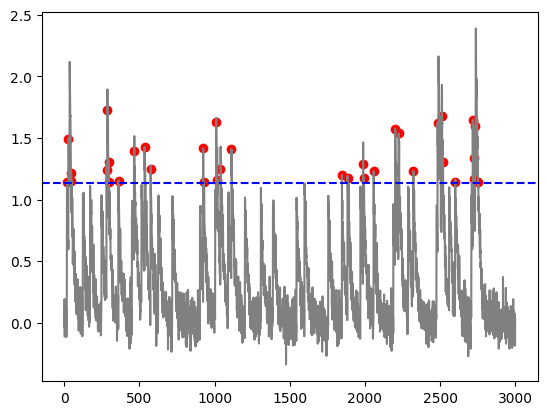

In [ ]:
treshold_factor = 2.0
det_treshold = np.mean(fluorescence_trace_1) + treshold_factor * np.std(fluorescence_trace_1)
is_active = fluorescence_trace_1 > det_treshold
onset_indices = np.where(np.diff(is_active.astype(int)) == 1)[0] + 1

plt.plot(fluorescence_trace_1, color='gray')
plt.axhline(det_treshold, color='b', linestyle='--')
plt.scatter(np.arange(len(fluorescence_trace_1))[onset_indices], fluorescence_trace_1[onset_indices], marker='o', color='r')

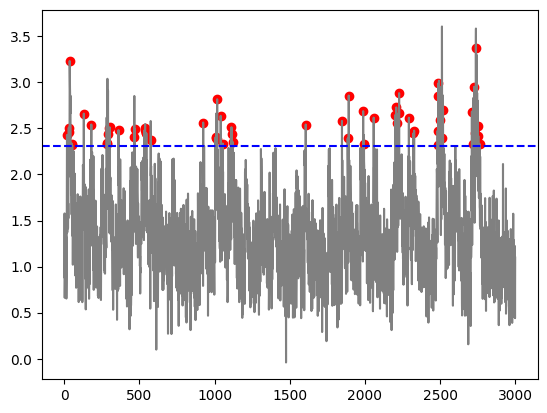

In [109]:
treshold_factor = 2.0
det_treshold = np.mean(fluorescence_trace_2) + treshold_factor * np.std(fluorescence_trace_2)
is_active = fluorescence_trace_2 > det_treshold
onset_indices = np.where(np.diff(is_active.astype(int)) == 1)[0] + 1

plt.plot(fluorescence_trace_2, color='gray')
plt.axhline(det_treshold, color='b', linestyle='--')
plt.scatter(np.arange(len(fluorescence_trace_2))[onset_indices], fluorescence_trace_2[onset_indices], marker='o', color='r')

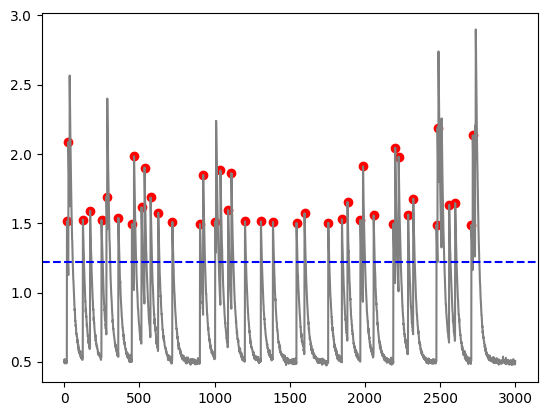

In [113]:
treshold_factor = 1.0
det_treshold = np.mean(fluorescence_trace_5) + treshold_factor * np.std(fluorescence_trace_5)
is_active = fluorescence_trace_5 > det_treshold
onset_indices = np.where(np.diff(is_active.astype(int)) == 1)[0] + 1

plt.plot(fluorescence_trace_5, color='gray')
plt.axhline(det_treshold, color='b', linestyle='--')
plt.scatter(np.arange(len(fluorescence_trace_5))[onset_indices], fluorescence_trace_5[onset_indices], marker='o', color='r')

**Converting indices to timestamps**

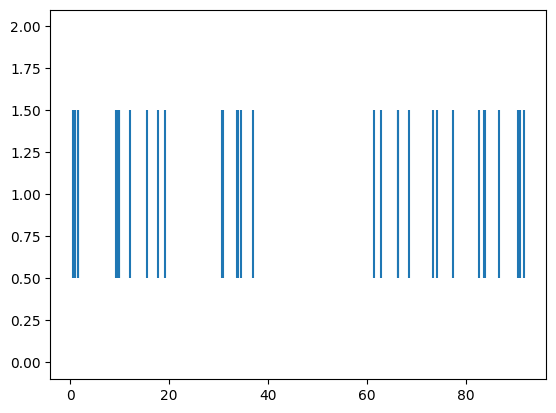

In [ ]:
frame_rate = 30 

treshold_factor = 2.0
det_treshold = np.mean(fluorescence_trace_1) + treshold_factor * np.std(fluorescence_trace_1)
is_active = fluorescence_trace_1 > det_treshold
onset_indices = np.where(np.diff(is_active.astype(int)) == 1)[0] + 1

onset_times_sec = onset_indices / frame_rate
plt.eventplot(onset_times_sec)

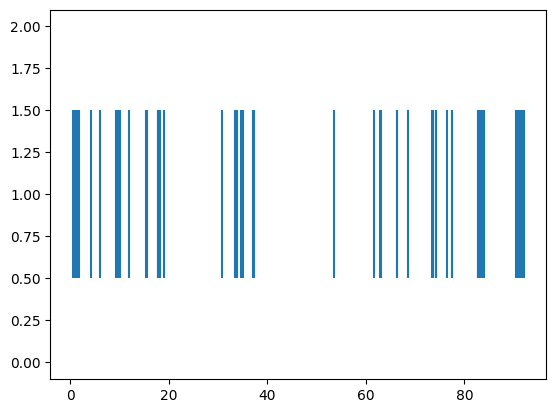

In [116]:
frame_rate = 30 

treshold_factor = 2.0
det_treshold = np.mean(fluorescence_trace_2) + treshold_factor * np.std(fluorescence_trace_2)
is_active = fluorescence_trace_2 > det_treshold
onset_indices = np.where(np.diff(is_active.astype(int)) == 1)[0] + 1

onset_times_sec = onset_indices / frame_rate
plt.eventplot(onset_times_sec)

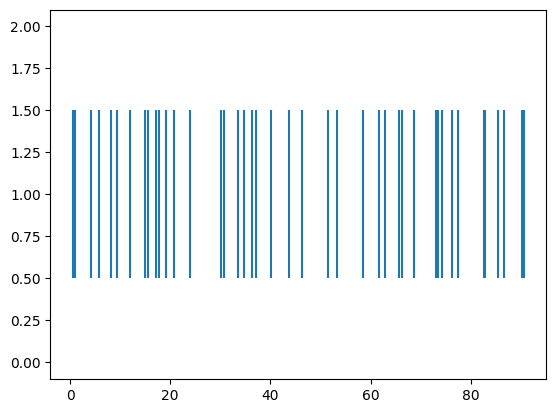

In [131]:
frame_rate = 30 

treshold_factor = 1.
det_treshold = np.mean(fluorescence_trace_5) + treshold_factor * np.std(fluorescence_trace_5)
is_active = fluorescence_trace_5 > det_treshold
onset_indices = np.where(np.diff(is_active.astype(int)) == 1)[0] + 1

onset_times_sec = onset_indices / frame_rate
plt.eventplot(onset_times_sec)

**Comparison with groun-truth spikes**

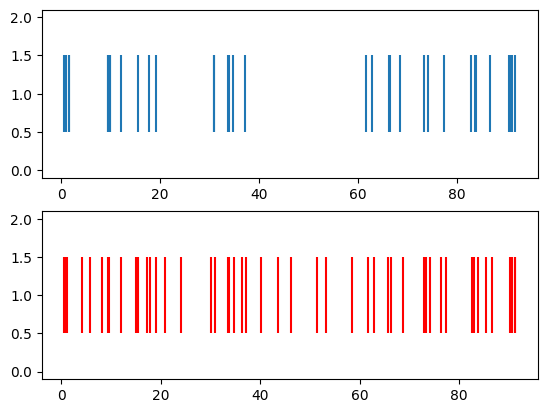

In [137]:
frame_rate = 30 

treshold_factor = 2.
det_treshold = np.mean(fluorescence_trace_1) + treshold_factor * np.std(fluorescence_trace_1)
is_active = fluorescence_trace_1 > det_treshold
onset_indices = np.where(np.diff(is_active.astype(int)) == 1)[0] + 1

true_spike_indices = np.where(spike_train_1 > 0)[0]

onset_times = onset_indices / frame_rate
true_spike_times = true_spike_indices / frame_rate

plt.subplot(211)
plt.eventplot(onset_times)

plt.subplot(212)
plt.eventplot(true_spike_times, color='r')

## Section 3: Inferring Spike Events with the OASIS Algorithm

In this section, we will introduce a more advanced method for extracting spike events from calcium traces using the OASIS algorithm. OASIS fits a generative model of calcium dynamics to estimate the most likely times of neuronal firing, returning both spike amplitudes and deconvolved activity. This approach improves temporal resolution and accounts for the shape of calcium transients, making it particularly suitable for precise event detection in high-throughput datasets. You will learn how to apply the `deconvolve()` function from the `oasis` package and extract spike timings from its output.

#### Learning Goals:
- Install and import the OASIS package and load a calcium trace for analysis.
- Use the `deconvolve()` function to obtain spike train (`s`), denoised trace (`c`) (`b`).
- Extract non-zero entries from the spike train and convert them to timestamps and amplitudes.

**Extract spike trains**

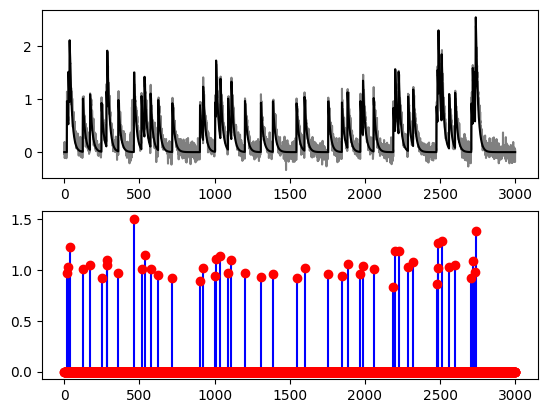

In [161]:
denoised_signal, spike_train, _, _, _ = deconvolve(fluorescence_trace_1)

plt.subplot(211)
plt.plot(fluorescence_trace_1, color='gray')
plt.plot(denoised_signal, color='k')

plt.subplot(212)
plt.stem(range(len(spike_train)), spike_train, basefmt=" ", linefmt='b-', markerfmt='ro');

**Extract spike indices and amplitudes**

Find all time points where the inferred spike amplitude is greater than zero.

c:\Users\sangeetha\miniforge3\envs\calim\Lib\site-packages\oasis\functions.py:817: FutureWarning: Beginning in SciPy 1.17, multidimensional input will be treated as a batch, not `ravel`ed. To preserve the existing behavior and silence this warning, `ravel` arguments before passing them to `toeplitz`.
  A = scipy.linalg.toeplitz(xc[np.arange(lags)],


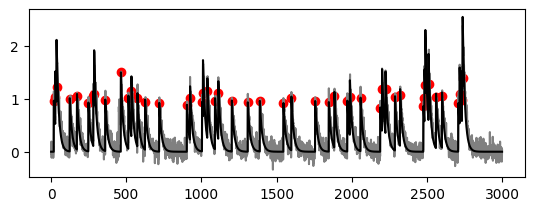

In [176]:
denoised_signal, spike_train, _, _, _ = deconvolve(fluorescence_trace_1)

spike_indices = np.where(np.round(spike_train) > 0)[0]
spike_amplitudes = spike_train[spike_indices]

plt.subplot(211)
plt.plot(fluorescence_trace_1, color='gray')
plt.plot(denoised_signal, color='k')
plt.scatter(np.arange(len(spike_train))[spike_indices], spike_train[spike_indices], color='r')

## Section 4: Visualizing Firing Rate from Event Timestamps

With a list of inferred spike times, we can now compute and visualize firing rates — a central measure in neuroscience data analysis. In this section, we will convert event timestamps into a time-resolved firing rate trace using binning methods. You will learn how to create histograms of spike counts over time, normalize the data to obtain rates in hertz, and apply optional smoothing for improved interpretability. Firing rate traces allow for direct comparisons across neurons, conditions, or experimental time windows.

#### Learning Goals:
- Define time bins using `np.arange()` based on the trace duration and desired temporal resolution.
- Count the number of events in each bin using `np.histogram()`.
- Normalize spike counts to obtain firing rates in Hz (`rate = count / bin_width`).
- Plot the resulting firing rate trace and apply smoothing using convolution or filtering functions.